# Best Secret Data Science Task

1. Ingestion of Data
2. Data Preprocessing (Missing Values, Datetime Conversion) / Feature Engineering
3. Analysis
4. ID List

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

# Ingestion of Data

In [139]:
df = pd.read_csv('bestsecret_analysis_test_data.csv')

In [140]:
df.head()

,CUSTOMER_ID,CUSTOMER_CREATED_TIMESTAMP,CUSTOMER_GENDER,CUSTOMER_REGISTRATION_CHANNEL,INVITER_CUSTOMER_ID,QTY_ORDERS,REVENUE,FIRST_ORDER_DATE,LAST_ORDER_DATE
0,1,2012-10-08 11:49:43.755,male,other,NaN,0,NaN,NaN,NaN
1,2,2013-08-26 15:44:11.173,female,viral,42921.0,0,NaN,NaN,NaN
2,3,2014-02-08 20:42:39.698,male,viral,42922.0,11,754.0499,2014-09-25 00:00:00.000,2017-01-29 00:00:00.000
3,4,2014-02-09 07:48:45.611,male,other,NaN,0,NaN,NaN,NaN
4,5,2014-04-02 01:09:20.439,female,viral,42923.0,0,NaN,NaN,NaN


In [141]:
df.isna().sum()

CUSTOMER_ID                          0
CUSTOMER_CREATED_TIMESTAMP           0
CUSTOMER_GENDER                    217
CUSTOMER_REGISTRATION_CHANNEL        1
INVITER_CUSTOMER_ID              35233
QTY_ORDERS                           0
REVENUE                          41121
FIRST_ORDER_DATE                 41121
LAST_ORDER_DATE                  41121
dtype: int64

# Data Preprocessing

For those customers, who haven't made an order yet, I use the logic of putting the user creation timestamp as a filler, which will be useful in the next step to create the time deltas.

In [142]:
df['FIRST_ORDER_DATE'] = df['FIRST_ORDER_DATE'].fillna(df['CUSTOMER_CREATED_TIMESTAMP'])
df['LAST_ORDER_DATE'] = df['LAST_ORDER_DATE'].fillna(df['CUSTOMER_CREATED_TIMESTAMP'])
df[['CUSTOMER_GENDER', 'CUSTOMER_REGISTRATION_CHANNEL']] = df[['CUSTOMER_GENDER', 'CUSTOMER_REGISTRATION_CHANNEL']].fillna('NA')
df[['REVENUE', 'INVITER_CUSTOMER_ID']] = df[['REVENUE', 'INVITER_CUSTOMER_ID']].fillna(0)

After converting the date columns into the datetime format, we then engineer the new features by calculating the delta between the account creation date and the date of the last order as well as the delta between the first and latest order in days.

Further we engineer the features revenue per order (total revenue/quantity of orders) and revenue per day (total revenue / days between account creation and last order)  

In [143]:
df['CUSTOMER_CREATED_TIMESTAMP'] = pd.to_datetime(df['CUSTOMER_CREATED_TIMESTAMP'])
df['FIRST_ORDER_DATE'] = pd.to_datetime(df['FIRST_ORDER_DATE'])
df['LAST_ORDER_DATE'] = pd.to_datetime(df['LAST_ORDER_DATE'])

df['days_created_last_ord'] = (df['LAST_ORDER_DATE'] - df['CUSTOMER_CREATED_TIMESTAMP']).dt.days
df['days_first_last_ord'] = (df['LAST_ORDER_DATE'] - df['FIRST_ORDER_DATE']).dt.days

df['rev_per_order'] = df['REVENUE'] / df['QTY_ORDERS']
df['rev_per_day'] = df['REVENUE'] / df['days_created_last_ord']

In [144]:
df[['rev_per_order', 'rev_per_day']] = df[['rev_per_order', 'rev_per_day']].fillna(0)

we now use the pandas implementation of one hot encoding on the registration channel to represent it numerically.

In [145]:
oh_channel = pd.get_dummies(df['CUSTOMER_REGISTRATION_CHANNEL'])
df = df.join(oh_channel)

We also one hot encode the gender, so that we have a numerical representation of it. I did this manually to show my ability to use for-loops.

In [146]:
isfem = []
for row in df['CUSTOMER_GENDER'].iteritems():
    if row[1] == 'female':
        isfem.append(1)
    else:
        isfem.append(0)
df['isfemale'] = isfem
#df = df.drop('CUSTOMER_GENDER', axis=1)

In order to get the count of invitations sent out by an user, we use the value count method to get the inviter ID and the corresponding number of invites sent out by the specific ID. We then save it as a dataframe to later merge it with the rest of the data.

In [147]:
id_counts = df['INVITER_CUSTOMER_ID'].value_counts().to_frame(name='invite_count')

Let's cut the dataframe down to the necessary features

In [148]:
df_shrt = df[['CUSTOMER_ID', 'CUSTOMER_REGISTRATION_CHANNEL', 'QTY_ORDERS', 'REVENUE', 'days_created_last_ord', 'days_first_last_ord',
              'isfemale','rev_per_order', 'rev_per_day', 'affiliate', 'other', 'partnerprogram', 'viral']]

Last, we merge the invite counts with the rest of the features

In [149]:
df_final = pd.merge(df_shrt, id_counts, left_on='CUSTOMER_ID', right_on=id_counts.index, how='left')
df_final['invite_count'] = df_final['invite_count'].fillna(0)

# Analysis

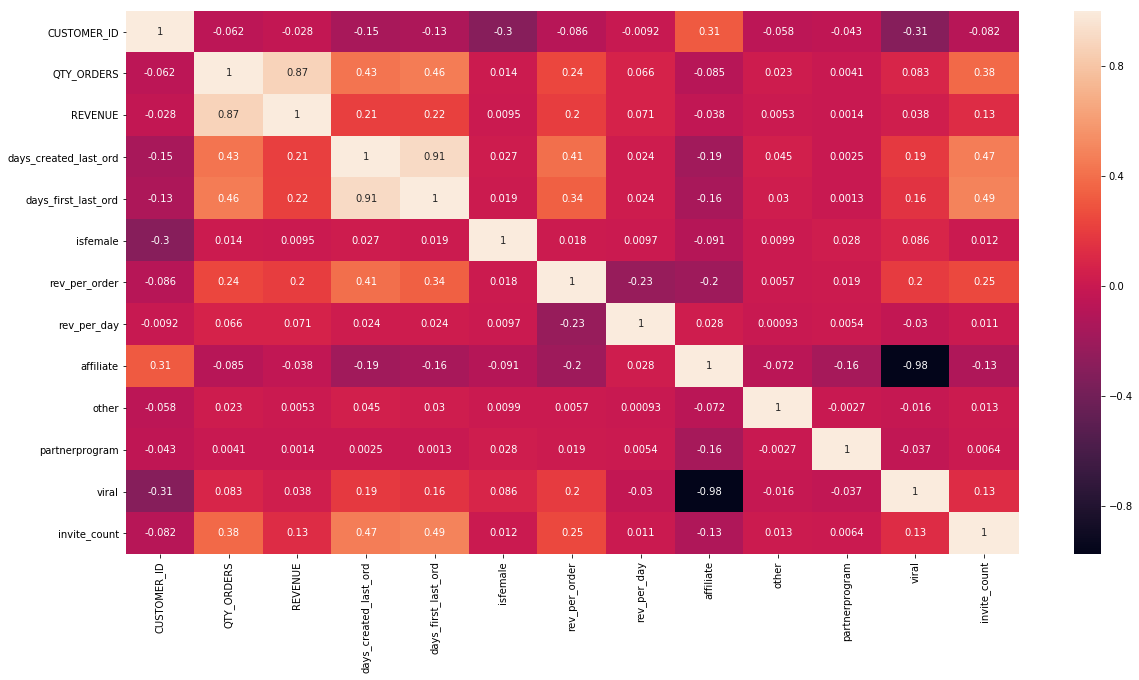

In [150]:
cm = df_final.corr()
plt.rcParams["figure.figsize"] = (20,10)


sn.heatmap(cm, annot=True)
plt.show()

Now, according to the wording of the task, we should sort the ID's by invite count as well as Revenue and Order Quantity as we want to target users that "show potential", who haven't invited other users so far (List B)

On the other hand, the above matrix shows that the invite count has some decent correlation with other features like 'days between first and last order', 'days between account creation and last order', 'number of orders by account' and 'revenue per order' (List A)


My idea would be to actually AB Test both lists against each other to see which approach yields better performance. Unfortunately, the task didn't mention specific KPIs or metrics by which performance is determined, so that would be something that would need to be clarified ahead of the test.


I have not shortened the lists, just sorted them because the task didn't specify how many users should be targeted. If the marketeers for example want to target 1000 users, they can simply take the first 1000 users of the list.

In [151]:
df_a = df_final.sort_values(['invite_count', 'days_first_last_ord', 'days_created_last_ord','QTY_ORDERS', 'rev_per_order',
                             'REVENUE'], ascending = (True, False, False, False, False, False))

df_a_ids = df_a['CUSTOMER_ID'].reset_index(drop=True)


df_b = df_final.sort_values(['invite_count', 'REVENUE', 'QTY_ORDERS'], 
                            ascending = (True, False, False))

df_b_ids = df_b['CUSTOMER_ID'].reset_index(drop=True)

In [153]:
df_a_ids.to_csv('BS_List_A.csv', index=False, header='ID')
df_b_ids.to_csv('BS_List_B.csv', index=False, header='ID')